In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

/home/etaylor/.conda/envs/detectron/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Aug_15_21:14:11_PDT_2021
Cuda compilation tools, release 11.4, V11.4.120
Build cuda_11.4.r11.4/compiler.30300941_0
torch:  1.9 ; cuda:  cu111
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from matplotlib import pyplot as plt

In [3]:
def cv2_imshow(im):
    image_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)# Plot the image
    plt.imshow(image_rgb)
    plt.title('Image')
    plt.show()

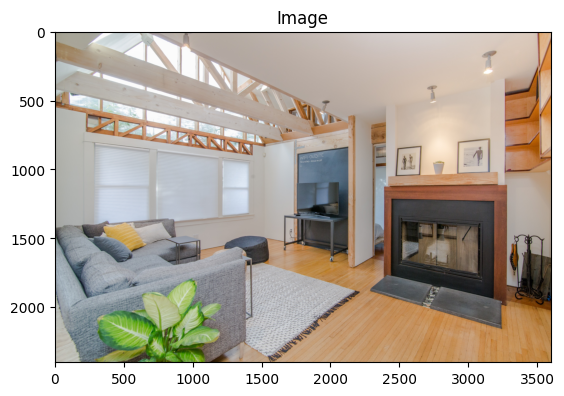

In [4]:
image_path = "src/segmentation/notebooks/detectron2/home_img.jpg"
im = cv2.imread(image_path)
cv2_imshow(im)

In [5]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[12/11 14:12:35 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/home/etaylor/.conda/envs/detectron/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
# look at the outputs - tensors and bounding boxes.
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([57, 58, 56, 41, 62], device='cuda:0')
Boxes(tensor([[   0.0000, 1347.5132, 1427.5134, 2344.6199],
        [ 319.6257, 1778.3317, 1254.3674, 2374.5938],
        [1225.4783, 1489.0127, 1552.1885, 1724.1802],
        [2737.8870,  949.4906, 2820.2825, 1040.8563],
        [1753.5376, 1090.4323, 2060.2041, 1319.3743]], device='cuda:0'))


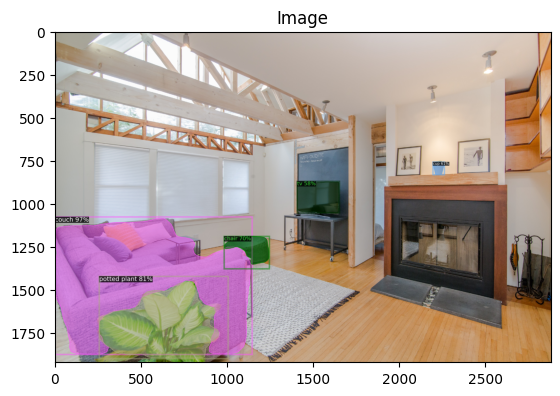

In [7]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

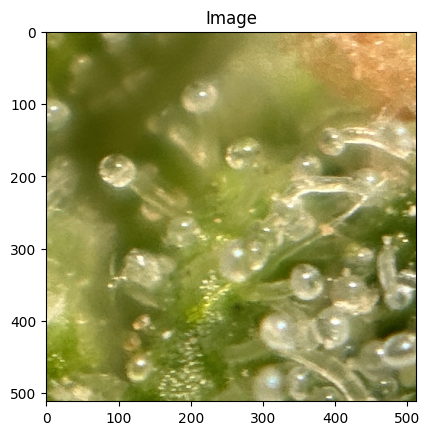

In [8]:
image_path = "/home/etaylor/images/processed_images/cannabis_patches/week9_15_06_2023/3x_regular/IMG_2150/IMG_2150_p9.png"
sci_im = cv2.imread(image_path)
cv2_imshow(sci_im)

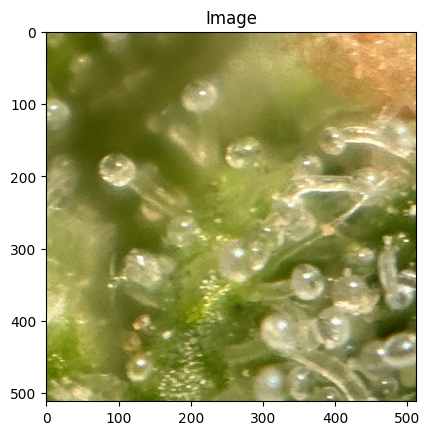

In [9]:
sci_outputs = predictor(sci_im)
sci_v = Visualizer(sci_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
sci_out = sci_v.draw_instance_predictions(sci_outputs["instances"].to("cpu"))
cv2_imshow(sci_out.get_image()[:, :, ::-1])

Get the json for the testing dataset

In [10]:
from src.segmentation.framework_handlers.detectron2_handler import convert_segments_to_detectron2_format

dataset_name = "etaylor/cannabis_patches_week9_15_06_2023_3x_regular_IMG_2153"
saving_json_path = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2153"
train_dataset, export_file, image_dir = convert_segments_to_detectron2_format(dataset_name, "v0.2", output_dir=saving_json_path)


Initializing dataset...
Preloading all samples. This may take a while...


100%|██████████| 11/11 [00:00<00:00, 206.74it/s]

Initialized dataset with 11 images.
Exporting dataset. This may take a while...



100%|██████████| 11/11 [00:00<00:00, 16.23it/s]

Exported to /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2153/export_coco-instance_etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2153_v0.2.json. Images in segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2153/v0.2


In [11]:
image_dir

'segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2153/v0.2'

In [12]:
from detectron2.data.datasets import register_coco_instances
train_images_path = "/home/etaylor/code_projects/thesis/segments/etaylor_all_cannabis_patches_multi_class/v0.1"
train_images_json = "/home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/01-12-2023_20-13-12/export_coco-instance_etaylor_all_cannabis_patches_multi_class_v0.1.json"
test_images_path = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2153/v0.2"
test_images_json = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2153/export_coco-instance_etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2153_v0.2.json"
register_coco_instances("my_dataset_train", {}, train_images_json, train_images_path)
register_coco_instances("my_dataset_val", {}, test_images_json, test_images_path)


In [13]:

train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")
     

[12/11 14:12:41 d2.data.datasets.coco]: Loaded 40 images in COCO format from /home/etaylor/code_projects/thesis/checkpoints/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/01-12-2023_20-13-12/export_coco-instance_etaylor_all_cannabis_patches_multi_class_v0.1.json


In [14]:

val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[12/11 14:12:41 d2.data.datasets.coco]: Loaded 11 images in COCO format from /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2153/export_coco-instance_etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2153_v0.2.json


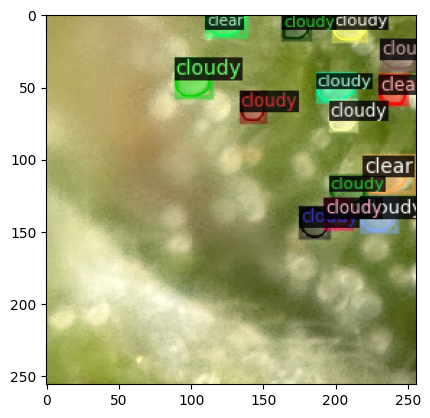

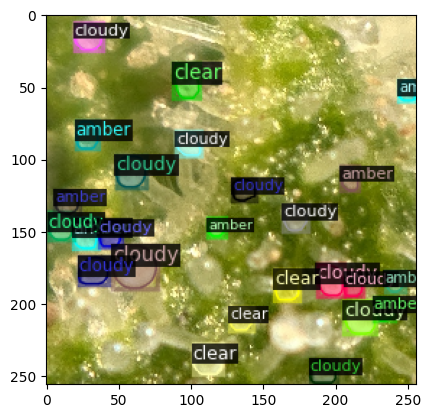

In [15]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)# Plot the image
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()
     

In [16]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/home/etaylor/code_projects/thesis/checkpoints/detectron2/detectron2_playground"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.INPUT.MASK_FORMAT = "bitmask"
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[12/11 14:12:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) 

In [17]:
trainer.train() #Start the training process

[12/11 14:12:43 d2.engine.train_loop]: Starting training from iteration 0


/home/etaylor/.conda/envs/detectron/lib/python3.9/site-packages/detectron2/data/detection_utils.py:446: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/home/etaylor/.conda/envs/detectron/lib/python3.9/site-packages/detectron2/data/detection_utils.py:446: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or mak

[12/11 14:12:48 d2.utils.events]:  eta: 0:03:59  iter: 19  total_loss: 4.037  loss_cls: 1.516  loss_box_reg: 0.3587  loss_mask: 0.6944  loss_rpn_cls: 1.328  loss_rpn_loc: 0.1208    time: 0.2409  last_time: 0.2455  data_time: 0.0378  last_data_time: 0.0057   lr: 4.9953e-06  max_mem: 3892M
[12/11 14:12:54 d2.utils.events]:  eta: 0:03:58  iter: 39  total_loss: 3.207  loss_cls: 1.381  loss_box_reg: 0.4318  loss_mask: 0.6888  loss_rpn_cls: 0.6353  loss_rpn_loc: 0.09611    time: 0.2451  last_time: 0.2481  data_time: 0.0091  last_data_time: 0.0066   lr: 9.9902e-06  max_mem: 4031M
[12/11 14:12:59 d2.utils.events]:  eta: 0:03:55  iter: 59  total_loss: 2.849  loss_cls: 1.206  loss_box_reg: 0.5494  loss_mask: 0.6758  loss_rpn_cls: 0.2957  loss_rpn_loc: 0.08975    time: 0.2486  last_time: 0.2349  data_time: 0.0089  last_data_time: 0.0055   lr: 1.4985e-05  max_mem: 4031M
[12/11 14:13:04 d2.utils.events]:  eta: 0:03:50  iter: 79  total_loss: 2.631  loss_cls: 1.038  loss_box_reg: 0.6809  loss_mask: 0

In [18]:
#TODO: continue with this tutorial: https://github.com/bnsreenu/python_for_microscopists/blob/master/330_Detectron2_Instance_3D_EM_Platelet.ipynb

In [24]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2/detectron2_playground/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [25]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[12/11 14:17:33 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/etaylor/code_projects/thesis/checkpoints/detectron2/detectron2_playground/model_final.pth ...


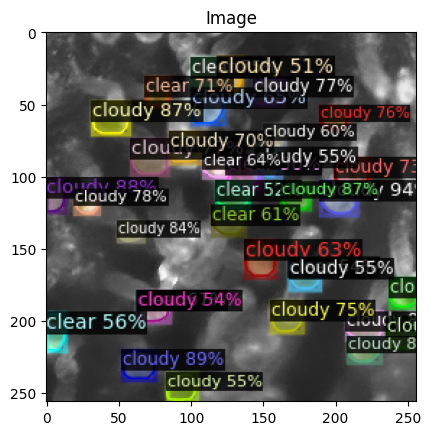

In [26]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [27]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
detectron2_playground_checkpoint_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2/detectron2_playground"
evaluator = COCOEvaluator("my_dataset_val", output_dir=f"{detectron2_playground_checkpoint_path}/output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[12/11 14:17:56 d2.data.datasets.coco]: Loaded 11 images in COCO format from /home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2153/export_coco-instance_etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2153_v0.2.json
[12/11 14:17:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/11 14:17:56 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/11 14:17:56 d2.data.common]: Serializing 11 elements to byte tensors and concatenating them all ...
[12/11 14:17:56 d2.data.common]: Serialized dataset takes 0.03 MiB
[12/11 14:17:56 d2.evaluation.evaluator]: Start inference on 11 batches


[12/11 14:17:58 d2.evaluation.evaluator]: Inference done 11/11. Dataloading: 0.0009 s/iter. Inference: 0.0501 s/iter. Eval: 0.0135 s/iter. Total: 0.0645 s/iter. ETA=0:00:00
[12/11 14:17:59 d2.evaluation.evaluator]: Total inference time: 0:00:00.475156 (0.079193 s / iter per device, on 1 devices)
[12/11 14:17:59 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.050099 s / iter per device, on 1 devices)
[12/11 14:17:59 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[12/11 14:17:59 d2.evaluation.coco_evaluation]: Saving results to /home/etaylor/code_projects/thesis/checkpoints/detectron2/detectron2_playground/output/coco_instances_results.json
[12/11 14:17:59 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[12/11 14:17:59 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[12/11 14:17:59 d2.evaluation.fast_eval_api]: CO

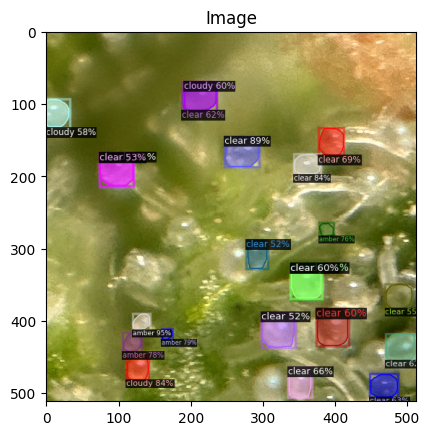

In [28]:
new_im_path = "/sise/home/etaylor/images/processed_images/cannabis_patches/week9_15_06_2023/3x_regular/IMG_2150/IMG_2150_p9.png"
new_im = cv2.imread(new_im_path)
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

#### Segment images and save object level information into a csv file.



In [32]:
import csv
from skimage.measure import regionprops, label


# Assuming you have already defined the 'predictor' object and loaded the model.
# Also, make sure 'metadata' is defined appropriately.

# Directory path to the input images folder
input_images_directory = "/home/etaylor/code_projects/thesis/segments/etaylor_cannabis_patches_week9_15_06_2023_3x_regular_IMG_2153/v0.1"

# Output directory where the CSV file will be saved
output_csv_path = "/home/etaylor/code_projects/thesis/checkpoints/detectron2/detectron2_playground/output_objects.csv"  # Replace this with the path to your desired output CSV file

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])  # Add more columns as needed for other properties

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Debugging: print class_labels and metadata.thing_classes
        #print("Class Labels:", class_labels)
        #print("Thing Classes:", train_metadata.thing_classes)

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)
        props = regionprops(labeled_mask)

        # Write the object-level information to the CSV file
        for i, prop in enumerate(props):
            object_number = i + 1  # Object number starts from 1
            area = prop.area
            centroid = prop.centroid
            bounding_box = prop.bbox

            # Check if the corresponding class label exists
            if i < len(class_labels):
                class_label = class_labels[i]
                class_name = train_metadata.thing_classes[class_label]
            else:
                # If class label is not available (should not happen), use 'Unknown' as class name
                class_name = 'Unknown'

            # Write the object-level information to the CSV file
            csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])  # Add more columns as needed for other properties

print("Object-level information saved to CSV file.")

Object-level information saved to CSV file.


/tmp/ipykernel_101224/255612423.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)


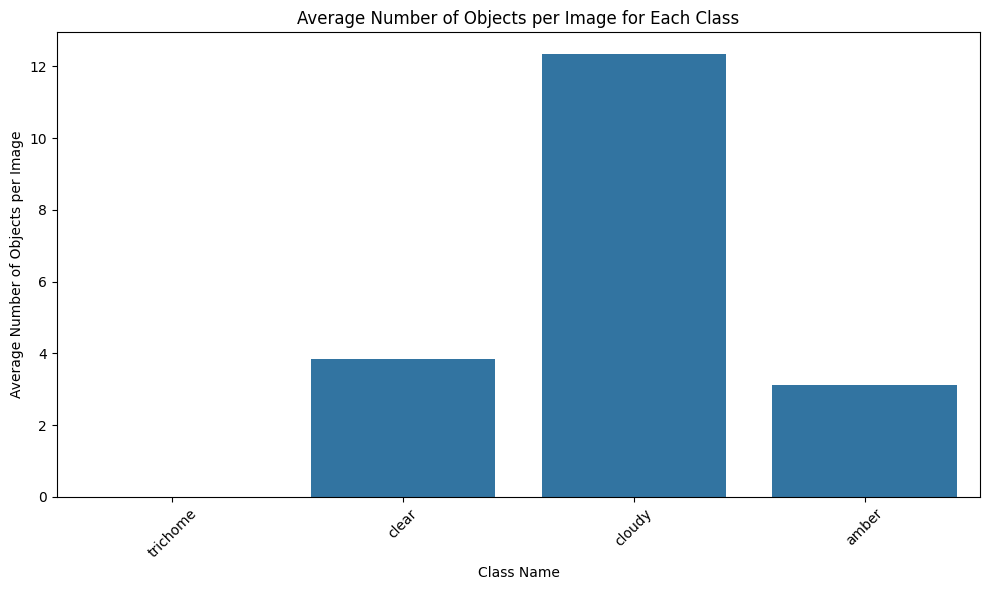

/tmp/ipykernel_101224/255612423.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)


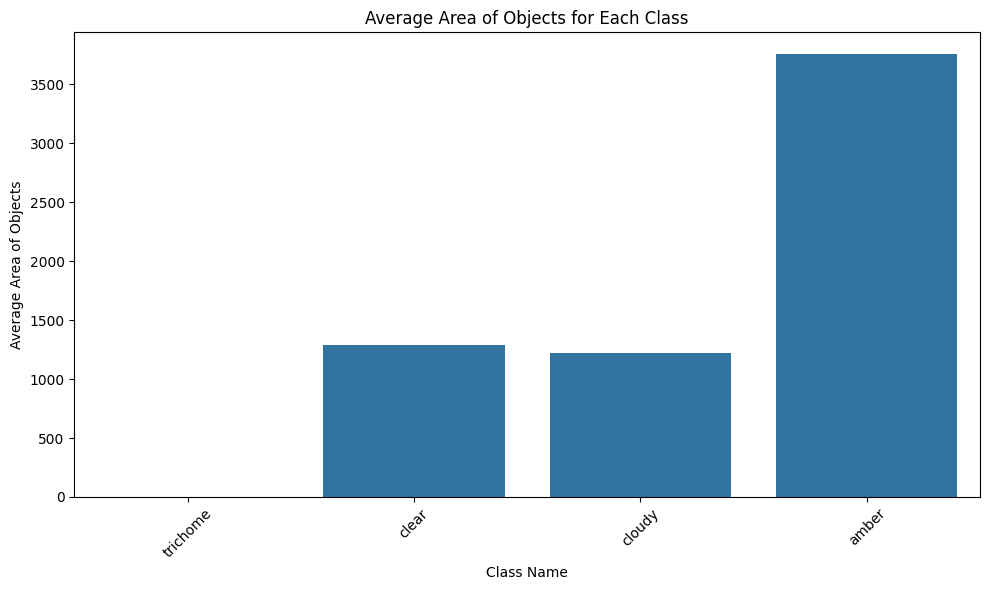

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the CSV file containing the object-level information
csv_file_path = output_csv_path

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Get class names from train_metadata.thing_classes
class_names = train_metadata.thing_classes

# Group the data by both "File Name" and "Class Name" and calculate the average number of objects per image for each class
# first group the data by both "File Name" and "Class Name" and count the number of objects within each group.
#Then, group the data by "Class Name" only and calculate the mean of the counts, which gives us the average number of objects per image for each class.
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()

# Plot: Average number of objects per image for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()


# Group the data by class and calculate the average area of objects for each class
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()

# Plot: Average area of objects for each class
plt.figure(figsize=(10, 6))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, ci=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()


In [ ]:
#TODO: Organize this code into organize code and functions that can be reused.